<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> ODE </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.25</h2>
</center>

## Some algorithms in this jupyter notebook have been obtained from the textbook "Lloyd N. Trefethen, Spectral Methods in MATLAB, SIAM, Philadelphia, 2000" and translated to Python.

<div id='toc' />

## Table of Contents

* [Introduction](#intro)
* [Initial Value Problemsl](#IVP)
    * [Four solvers](#solver)
        * [Convergence](#conver)
    * [High order, higher dimensions and dynamical systems](#high)
* [Boundary Value Problems](#bvp)
    * [Shooting Method](#MD)
    * [Finite Differences](#DD)
* [Acknowledgements](#acknowledgements)

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt # type: ignore
from matplotlib import pyplot # type: ignore
import numpy as np # type: ignore

from scipy.integrate import solve_ivp # type: ignore
from scipy import optimize # type: ignore
from pylab import * # type: ignore
from numpy import linalg as LA # type: ignore
from matplotlib.legend_handler import HandlerLine2D # type: ignore
from scipy.linalg import toeplitz # type: ignore
from scipy.optimize import root # type: ignore
from ipywidgets import interact, RadioButtons, Checkbox # type: ignore
import sympy as sym # type: ignore
import matplotlib as mpl # type: ignore
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from mpl_toolkits.axes_grid1 import make_axes_locatable # type: ignore
sym.init_printing()

# Global parameter that controls the figure's size
L = 15

# Source: https://github.com/tclaudioe/Scientific-Computing/blob/master/SC5/02%20Differentiation%20matrices.ipynb
def plot_matrices_with_values(ax,M,FLAG_test=True):
    N=M.shape[0]
    cmap = plt.get_cmap('GnBu')
    im = ax.matshow(M, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    if FLAG_test:
        for i in np.arange(0, N):
            for j in np.arange(0, N):
                ax.text(i, j, '{:.2f}'.format(M[i,j]), va='center', ha='center', color='r')
    return

<div id='intro' />

# Introduction
[Back to TOC](#toc)

In this jupyter noteboon we will study several numerical methods for solving ordinary differential equations (ODEs).
In particular we will study Initial Value Problems (IVP) and Boundary Value Problems (BVP), their principal numerical methods of numerical resolution, and their stability and convergence.

<div id='IVP' />

# Initial Value Problems
[Back to TOC](#toc)

An IVP corresponds to an ordinary differential equation of the form:
$$ \dot{y}(t) = f(t,y(t)), \quad t\in]t_0,T]$$
subject to an initial condition,
$$ y(t_0) = y_0. $$

<div id='solver' />

# Four solvers
[Back to TOC](#toc)

Here we list a few solvers, just notice that we are only hightliting their one-time-step version:

- **Euler's Method**:

$$
\begin{align*}
    y_{i+1} &= y_i + h\,f(t_i,y_i)
\end{align*}
$$

- **Backward Euler Method**:
$$
\begin{align*}
    y_{i+1} &= y_i + h\,f(t_i+h,y_{i+1})
\end{align*}
$$

- **Runge-Kutta of second order (RK2)**:

$$
\begin{align*}
    k_{1} &= f(t_i,y_i) \\
    y_{i+1} &= y_i + h\,f\left(t_i + \dfrac{h}{2}, y_i + \dfrac{h}{2}\,k_1\right)
\end{align*}
$$

- **Runge-Kutta of 4th order (RK4)**:

$$
\begin{align*}
    k_{1} &= f(t_i,y_i) \\
    k_{2} &= f(t_i + \dfrac{h}{2}, y_i + \dfrac{h}{2}k_1) \\
    k_{3} &= f(t_i + \dfrac{h}{2}, y_i + \dfrac{h}{2}k_2) \\
    k_{4} &= f(t_i + h, y + h\,k_3) \\
    y_{i+1} &= y_i + \dfrac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4) 
\end{align*}
$$

For all this methods $h$ is the time-step it will advance the solution.
The previous algorithms only advance one time step the solution, so it should be applied the corresponding time steps expected such that it goes from the initial time $t_0$ until the final time $T$.

In [2]:
# Forward Euler Method
def eulerMethod_one_step(yi,ti,f,h):
    return yi+h*f(ti,yi)

# Backward Euler for 1D and nD problems
def backwardEuler_one_step(yi,ti,f,h):
    f_hat = lambda x:  x - yi - f(ti+h,x)*h
    if isinstance(yi,(int,float)):
        out = optimize.root_scalar(f_hat,x0=yi)
        if out.converged:
            return out.root
        else:
            raise Exception("Backward Euler 1D: We couldn't find the root. Select/build another solver.")
    else:
        out = optimize.root(f_hat,yi)
        if out.success:
            return out.x
        else:
            raise Exception("Backward Euler nD: We couldn't find the root. Select/build another solver.")

# Runge-Kutta of Second order
def RK2_one_step(yi,ti,f,h):
    k1=f(ti,yi)
    return yi+h*f(ti+h/2.0,yi+h/2.0*k1)

# Runge-Kutta 
def RK4_one_step(yi,ti,f,h):
    k1=f(ti,yi)
    k2=f(ti+h/2.0,yi+(h/2.0)*k1)
    k3=f(ti+h/2.0,yi+(h/2.0)*k2)
    k4=f(ti+h,yi+h*k3)
    return yi+(h/6.0)*(k1+2.0*k2+2.0*k3+k4)

Here we define the several steps solvers.
These are the version that will be used later on in the code.

In [3]:
# This implemantions have been upgraded respect to the ones included in the classnotes to handle
def eulerMethod(t0,T,N,y0,f):
    t = np.linspace(t0,T,N+1)
    h = (T-t0)/N
    if isinstance(y0,(int,float)):
        y = np.zeros(N+1)
    else:
        y = np.zeros((N+1,len(y0)))
    y[0] = y0
    for i in np.arange(N):
        y[i+1] = eulerMethod_one_step(y[i],t[i],f,h)
    return t, y

def backwardEulerMethod(t0,T,N,y0,f):
    t = np.linspace(t0,T,N+1)
    h = (T-t0)/N
    if isinstance(y0,(int,float)):
        y = np.zeros(N+1)
    else:
        y = np.zeros((N+1,len(y0)))
    y[0] = y0
    for i in np.arange(N):
        y[i+1] = backwardEuler_one_step(y[i],t[i],f,h)
    return t, y

def RK2(t0,T,N,y0,f):
    t = np.linspace(t0,T,N+1)
    h = (T-t0)/N
    if isinstance(y0,(int,float)):
        y = np.zeros(N+1)
    else:
        y = np.zeros((N+1,len(y0)))
    y[0] = y0
    for i in np.arange(N):
        y[i+1] = RK2_one_step(y[i],t[i],f,h)
    return t, y

def RK4(t0,T,N,y0,f):
    t = np.linspace(t0,T,N+1)
    h = (T-t0)/N
    if isinstance(y0,(int,float)):
        y = np.zeros(N+1)
    else:
        y = np.zeros((N+1,len(y0)))
    y[0] = y0
    for i in np.arange(N):
        y[i+1] = RK4_one_step(y[i],t[i],f,h)
    return t, y

### 1D Example

In this example we will solve the logistic equation $\dot{y}(t) = y(t)(1-y(t))$ for several inital conditions $y_0$.

In [4]:
# Logistic Equation
def f(t,y):
    return np.array(y*(1-y))

# First Example
def change_N_and_y0_1st_Example(N=20,y0=0.1, ODEsolver=eulerMethod):
    t0 = 0
    T  = 4
    t, y = ODEsolver(t0,T,N,y0,f)
    fig = plt.figure()
    ax  = fig.gca()
    ax.axis([0, 4, -1, 2])
    # Plotting stationary states for this problem.
    t = np.linspace(t0,T,N+1)
    plt.plot(t,t*0+1,'b-',lw=5, alpha=0.5, label='Stationary state y=1')
    plt.plot(t,t*0,'r-',lw=5, alpha=0.5, label='Stationary state y=0')
    # Plotting numerical solution.
    plt.plot(t,y,'.',label=r'$y_i$')
    
    plt.grid(True)
    ax.legend(loc='lower left', ncol=1, fancybox=True, shadow=True, numpoints=1, bbox_to_anchor=(1,0))
    plt.show()
    
radio_button_ODEsolvers=RadioButtons(
    options=[('Euler\'s Method',eulerMethod),('Backward Euler Method',backwardEulerMethod),('RK2',RK2),('RK4',RK4)],
    value=eulerMethod,
    description='ODE solver:',
    disabled=False
)    

interact(change_N_and_y0_1st_Example,N=(3,100,1),y0=(-0.5,2,0.1), ODEsolver=radio_button_ODEsolvers)

interactive(children=(IntSlider(value=20, description='N', min=3), FloatSlider(value=0.1, description='y0', ma…

<function __main__.change_N_and_y0_1st_Example(N=20, y0=0.1, ODEsolver=<function eulerMethod at 0x11fe3d760>)>

Now, solve several initial conditions at the same time.

In [5]:
def plot_log_eq(N=30,ODEsolver=eulerMethod):
    t0 = 0
    T = 4
    fig = plt.figure(figsize=(L/2,L/2))
    fig.clf()
    ax = fig.gca()
    ax.axis("equal")
    ax.grid(True)
    ax.set_title("Numerical Approximations and Direction Field")
    ax.axis([0, 4, -2, 2])
    
    # Plotting the stationary states
    t = np.linspace(t0,T,N+1)
    plt.plot(t,t*0+1,'b-',lw=5, alpha=0.5, label='Stationary state y=1')
    plt.plot(t,t*0,'r-',lw=5, alpha=0.5, label='Stationary state y=0')
    plt.legend(loc='best')

    # Solving over time for each method.
    for y0 in np.linspace(0,5,40): 
        t_times, y_output = ODEsolver(t0,T,N,y0,f)
            
        if y0>=1:
            plt.plot(t_times,y_output,'k-',alpha=0.2)
        else:
            plt.plot(t_times,y_output,'k-',alpha=0.8)
        plt.plot(t_times,y_output,'.')
        
    X,Y = np.meshgrid(np.arange(0,4,.2), np.arange(-2,2,.2))
    theta = np.arctan(f(0,Y))
    U = np.cos(theta)
    V = np.sin(theta)
    plt.quiver(X,Y,U,V,alpha=0.5)
    
interact(plot_log_eq,N=(5,100,1),ODEsolver=radio_button_ODEsolvers)

interactive(children=(IntSlider(value=30, description='N', min=5), RadioButtons(description='ODE solver:', opt…

<function __main__.plot_log_eq(N=30, ODEsolver=<function eulerMethod at 0x11fe3d760>)>

<div id='conver' />

## Convergence
[Back to TOC](#toc)

This is very important! Let's study it!

To talk about the convergence, we need to have in mind the order of each method.
In particular, we will consider that $y(T)$ denotes the exact solution at the final time $T$ that need to solve the ODE, and $y_N$ be the approximation of the solution at the final time $T=t_N$.
In simple words, we can say the following:

- Euler's method is a first order method since $y(T)=y_N+\mathcal{O}(h)$. This means that if $h$ is reduce by half, then the error is reduced by half.
- Backward Euler method is a first order method since $y(T)=y_N+\mathcal{O}(h)$. This means that if $h$ is reduce by half, then the error is reduced by half.
- RK2 is a second order method since $y(T)=y_N+\mathcal{O}(h^2)$. This means that if $h$ is reduce by half, then the error is reduced by 4.
- RK4 is a forth order method since $y(T)=y_N+\mathcal{O}(h^4)$. This means that if $h$ is reduce by half, then the error is reduced by 16.

To validate this, we will solve numerically the following problem,
$$
\begin{align*}
    \dot{y}(t)&=-3\,y(t)+6\,t+5, \quad t\in]0,0.5]\\
    y(0)&=3,
\end{align*}
$$
for which we know the solution $y(t)=2\exp(-3t)+2t+1$.

In [6]:
t0 = 0
T  = 0.5
y0 = 3.0
def f(t,y):
    return np.array(-3*y+6*t+5)
y_sol = lambda t: 2.*np.exp(-3.*t)+2.*t+1

Text(0, 0.5, 'Error$=|y(T)-y_{N}|$')

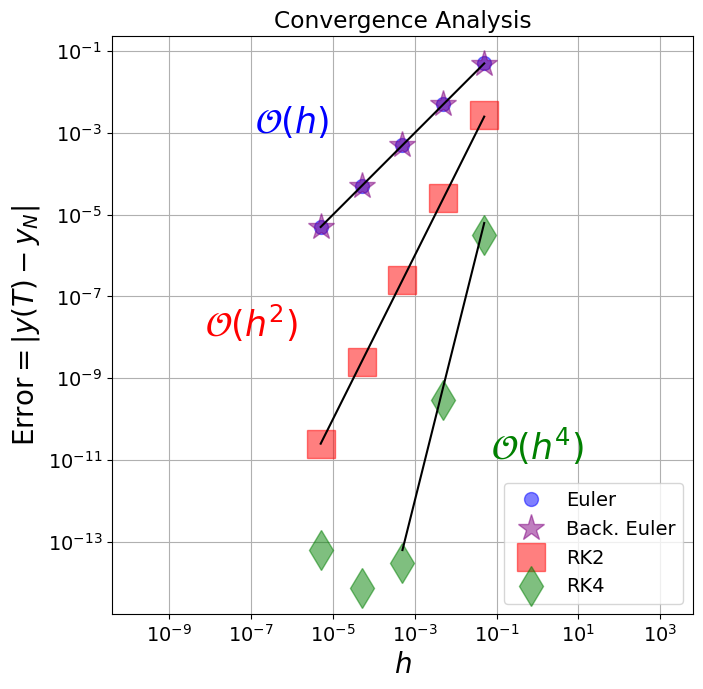

In [7]:
fig = plt.figure(figsize=(L/2,L/2))
fig.clf()
ax = fig.gca()
ax.axis('equal')
ax.grid(True)
ax.set_title('Convergence Analysis')

N_list = np.logspace(1,5,5,dtype=int)
for N in N_list:
    
    h = (T-t0)/N
    t_times, y_output = eulerMethod(t0,T,N,y0,f)
    plt.loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'b.',ms=20,label='Euler',alpha=.5)
    
    h = (T-t0)/N
    t_times, y_output = backwardEulerMethod(t0,T,N,y0,f)
    plt.loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'*', color='purple',ms=20,label='Back. Euler',alpha=.5)

    t_times, y_output = RK2(t0,T,N,y0,f)
    plt.loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'rs',ms=20,label='RK2',alpha=.5)

    t_times, y_output = RK4(t0,T,N,y0,f)
    plt.loglog(h,abs(y_output[-1]-y_sol(t_times[-1])),'gd',ms=20,label='RK4',alpha=.5)
    if N==N_list[0]:
        plt.legend(numpoints=1, loc='lower right')

h_list=T/N_list

plt.loglog(h_list,h_list,'k-')
plt.text(10**(-6),10**(-3),r'$\mathcal{O}(h)$', fontsize=25, horizontalalignment='center', color='b')
plt.loglog(h_list,np.power(h_list,2.),'k-')
plt.text(10**(-7),10**(-8),r'$\mathcal{O}(h^2)$', fontsize=25, horizontalalignment='center', color='r')
plt.loglog(h_list[:-2],np.power(h_list[:-2],4.),'k-')
plt.text(10**(0),10**(-11),r'$\mathcal{O}(h^4)$', fontsize=25, horizontalalignment='center', color='g')
plt.xlabel(r'$h$')
plt.ylabel(r'Error$=|y(T)-y_{N}|$')

<div id='high' />

# High order, higher dimensions and dynamical systems
[Back to TOC](#toc)

Why do we study higher order problems?

Because they are so cool!

### The Van der Pol oscillator

The equation that model de Van der Pol oscillator is the following:
$$\ddot{y}-\mu\,(1-y^2)\,\dot{y} + y = 0,$$ 
with $y(0)=2$ and $\dot{y}(0)=0$,
where $\mu$ is a scalar parameter that regulates the non-linearity of the problem and the strength of the damping.
See https://en.wikipedia.org/wiki/Van_der_Pol_oscillator.

So, since it has second derivatives respecto to time, we need to translate it to a dynamical system with the following change of variables:
$$
\begin{align*}
    y_1(t) &= y(t),\\
    y_2(t) &= \dot{y}(t).
\end{align*}
$$
Thus,
$$
\begin{align*}
    \dot{y}_1 &= \dot{y} = y_2,\\
    \dot{y}_2 &= \ddot{y} = \mu (1-y^2) \dot{y} - y = \mu (1-y_1^2) y_2 - y_1,
\end{align*}
$$
with $y_1(0)=2$ and $y_2(0)=0$.

In [8]:
def f_vdp(t,y,mu=10):
    y1 = y[0]
    y2 = y[1]
    return np.array([y2, mu*(1-y1**2)*y2-y1])

def f_vdp_eig_jacobian(t,y,mu=10):
    J=[[0,1],[-(2*mu*y[0]*y[1]+1), mu*(1-y[0]**2)]]
    lambs,vs= LA.eig(J)
    return lambs

In [9]:
def plotting_vdp(y01=2, y02=0, N=20000, T=200, mu=10, ODEsolver=eulerMethod):
    
    y0=np.array([y01, y02])
        
    f= lambda t,y: f_vdp(t,y,mu)
    
    t0=0
    
    t_times, y_output = ODEsolver(t0,T,N,y0,f)

    fig = plt.figure(figsize=(L,L/2))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.grid(True)
    ax1.set_title('Numerical Approximation')
    ax1.plot(t_times,y_output[:,0],'-', label=r'$y_1(t)$', alpha=0.5)
    ax1.set(xlabel='t')
    ax1.plot(t_times,y_output[:,1],'-r', label=r'$y_2(t)$', alpha=0.5)
    ax1.legend(loc='best')

    ax2.grid(True)
    ax2.set_title('Phase Portrait')
    ax2.plot(y_output[:,0],y_output[:,1],'-')
    ax2.set(xlabel='$y=y_1$', ylabel=r'$\dot{y}=y_2$')

interact(plotting_vdp,y01=(-3,3,0.1), y02=(-3,3,0.1),
         N=(10,10000,10),T=(10,200,10),
         mu=(1,50,0.1),ODEsolver=radio_button_ODEsolvers)

interactive(children=(FloatSlider(value=2.0, description='y01', max=3.0, min=-3.0), FloatSlider(value=0.0, des…

<function __main__.plotting_vdp(y01=2, y02=0, N=20000, T=200, mu=10, ODEsolver=<function eulerMethod at 0x11fe3d760>)>

### Lotka-Volterra model

This instance models the evolution of the average population of two species living in a closed system.
The species number 1 is considered that feeds itself with an unlimited amount of food and the species number 2 feeds itself with species number 1.
We will denote the average population of species number 1 as $y_1(t)$ and the average population of species number 2 as $y_2(t)$.

So, if we consider that there is no presence of species number 2 in the system, then species number 1 will grow exponentially, this means $\dot{y}_1=y_1$.
On the other case, if no presence of species number 1 in the system, then species number 2 will decay exponentially as follows $\dot{y}_2=-y_2$.
However, we are not interested in the extreme cases, how can we understand the dynamics when there exists these two species together interacting?
This is modeled by the Lotka-Volterra dynamical system:
$$
\begin{align*}
    \dot{y}_1(t)&=(1-y_2(t)/\mu_2)\,y_1(t),\\
    \dot{y}_2(t)&=-(1-y_1(t)/\mu_1)\,y_2(t),\\
    y_1(0)&=400,\\
    y_2(0)&=100,
\end{align*}
$$
where $\mu_1$ and $\mu_2$ are normalization constants.

In [10]:
mu1=300
mu2=200
def f_predprey(t,y,mu1=mu1,mu2=mu2):
    y1 = y[0]
    y2 = y[1]
    return np.array([(1-y2/mu2)*y1, -(1-y1/mu1)*y2])

def f_predprey_jacobian(t,y,mu1=mu1,mu2=mu2):
    J=[[1-y[1]/mu2,-y[0]/mu2],[y[1]/mu1, -(1-y[0]/mu1)]]
    lambs,vs= LA.eig(J)
    return lambs

In [11]:
def plotting_predprey(y01=70, y02=100, N=1000, T=30, ODEsolver=eulerMethod):
    
    y0  = np.array([y01, y02])
    f   = lambda t,y: f_predprey(t,y)
    t0  = 0
    
    t_times, y_output = ODEsolver(t0,T,N,y0,f)
    
    plt.figure(figsize=(L,L/2))
    plt.title('Numerical Approximation')
    plt.plot(t_times,y_output[:,0],'-')
    plt.plot(t_times,y_output[:,1],'r-')
    plt.grid(True)

interact(plotting_predprey,y01=(0,1000,10),y02=(0,1000,10),
         N=(10,1000,10),T=(10,200,10),
         ODEsolver=radio_button_ODEsolvers)

interactive(children=(IntSlider(value=70, description='y01', max=1000, step=10), IntSlider(value=100, descript…

<function __main__.plotting_predprey(y01=70, y02=100, N=1000, T=30, ODEsolver=<function eulerMethod at 0x11fe3d760>)>

## Now solving the following equation
$$
\begin{align*}
    \dot{y}_1(t) &= y_2(t),\\
    \dot{y}_2(t) &= -y_1(t),
\end{align*}
$$
with $y_1(0)=1$ and $y_2(0)=0$.

What functions are these? Do you recognize them?

In [12]:
def f_trig(t,y):
    y1 = y[0]
    y2 = y[1]
    return np.array([y2, -y1])

def f_trig_jacobian(t,y):
    return np.array([0.+1.j, 0.-1.j])

def plotting_f_trig(y01=1, y02=0, N=100, T=2*np.pi, ODEsolver=eulerMethod):

    y0  = np.array([y01, y02])
    f   = lambda t,y: f_trig(t,y)
    t0  = 0
    t_times, y_output = ODEsolver(t0,T,N,y0,f)

    plt.figure(figsize=(L,L/2))
    plt.title('Numerical Approximation')
    plt.plot(t_times,y_output[:,0],'-')
    plt.plot(t_times,y_output[:,1],'r-')
    plt.grid(True)

interact(plotting_f_trig,y01=(-2,2,0.1),y02=(-2,2,0.1),
         N=(10,1000,10),T=(1,10*np.pi,0.1),
         ODEsolver=radio_button_ODEsolvers)

interactive(children=(FloatSlider(value=1.0, description='y01', max=2.0, min=-2.0), FloatSlider(value=0.0, des…

<function __main__.plotting_f_trig(y01=1, y02=0, N=100, T=6.283185307179586, ODEsolver=<function eulerMethod at 0x11fe3d760>)>

## Last but not least, solving:
$$
\begin{align*}
    \dot{y}(t) &= \lambda\,y(t),\\
\end{align*}
$$
with $y(0)=1$.

What function is this? Do you recognize it?

In [13]:
def f_exp(t,y,lam=-1):
    return lam*y

def f_exp_jac(t,y,lam=-1):
    return lam

def plotting_f_exp(y0=1, N=100, T=10, lam=-1, ODEsolver=eulerMethod):
    
    f   = lambda t,y: f_exp(t,y, lam)
    t0  = 0
    t_times, y_output = ODEsolver(t0,T,N,y0,f)
    
    # Plotting 
    plt.figure(figsize=(L,L/2))
    plt.title('Numerical Approximation')
    plt.plot(t_times,y_output[:],'.b')
    plt.plot(t_times,y_output[:],'k-',alpha=0.5)
    plt.grid(True)

interact(plotting_f_exp,y0=(-2,2,0.1),
         N=(5,1000,10),T=(1,20,1), lam=(-2,2,0.1),
         ODEsolver=radio_button_ODEsolvers)

interactive(children=(FloatSlider(value=1.0, description='y0', max=2.0, min=-2.0), IntSlider(value=100, descri…

<function __main__.plotting_f_exp(y0=1, N=100, T=10, lam=-1, ODEsolver=<function eulerMethod at 0x11fe3d760>)>

<div id='bvp' />

# Boundary Value Problems
[Back to TOC](#toc)

An instance of a BVP corresponds to a ordinary differential equation of the following form:
$$ y''(x) = f(x,y(x),y'(x)),$$
with the following boundary conditions,
$$
\begin{align*}
    y(a) &= y_a,\\
    y(b) &= y_b.
\end{align*}
$$
To undertand them better, let's find a numerical approximation of the following problem:
$$
\begin{align*}
    y''(x) &= 4\,y(x),\\
    y(0)   &= y_0,\\
    y(1)   &= y_n.
\end{align*}
$$

<div id='MD' />

## Shooting Method
[Back to TOC](#toc)

This method takes advantage that we already know how to handle IVP and uses that knowledge to find a numerical approximation of an BVP.
The main steps are the followings:
- We have a BVP on the form: 
    $$
    \begin{align*}
        y''(x) &= f(x,y(x),y'(x)),\\
        y(a)   &= y_a,\\
        y(b)   &= y_b.
    \end{align*}
    $$
- Let's considerer the following steps to translate the BVP to an IVP:
    1. $x \rightarrow t$, this implies that $t_0=a$ and $T=b$.
    2. $$\begin{align*}
            \ddot{y}(t)   &= f(t,y(t),\dot{y}(t)),\\
            y(t_0)        &= y_a,\\ 
            \dot{y}(t_0)  &= \alpha.
       \end{align*}
       $$
       **Warning**: We actually don't know $\alpha$ but we do need it since we treating the previous problem as a IVP. What we do have is $y(b)=y(T)=y_b$.
    3. So, since we don't have $\alpha$, we need to find it by solving the following 1D root: $F(\alpha) = y_N^{(\alpha)} - y_b$, where $y_N^{(\alpha)}$ denotes the IVP approximation at time $t=T$ considering $\alpha$ for the initial condition of $\dot{y}(t_0)$.
    4. After we find the root for $F(\alpha)$, we can say we have found a numerical approximation of $y(x)$ since we have a numerical approximation that satisfies the ODE and also the boundary condition defined on the interval $[a,b]$. This is wonderful!

Notice however that the function $F(\alpha)$ is the output of the execution of an algorithm, so we only expect it to be continuous.
For instance it will be interesting to apply the Bisection method here!
The main disadvantage of this algorithm is that we need to solve several IVPs to actually find the right one, the good news is that we are re-using previous knowledge in a new type of problems!

In [14]:
# BVP: y''(x)= 4*y(x), y(0)=1, and y(1)=3, x \in [0,1].
# Dynamical system:
# y1=y  -> y1'=y'=y2
# y2=y' -> y2'=y''=4*y=4*y1.
# y1(0) = 1, (and we know y(1)=3)
# y1(1) = 3.
# y2(0) = alpha, we don't know it.
def f(t,y):
    return np.array([y[1],4*y[0]])
    #return np.array([y[1],t])

In [15]:
def shooting_method_101(alpha=-1, N=50, ya=1, yb=3, ODEsolver=eulerMethod):
#def shooting_method_101(alpha=0, N=50, ya=-1, yb=2, ODEsolver=eulerMethod):
    t0 = 0
    T  = 1
    y0 = np.array([ya,alpha])
    t_times, y_output = ODEsolver(t0,T,N,y0,f)
    h = (T-t0)/N
    
    fig = plt.figure(figsize=(L/2,L/2))
    ax = fig.gca()
    plt.grid(True)
    plt.title("Numerical Approximation")
    plt.plot(t_times,y_output[:,0],'r.',ms=12,alpha=0.5,label=r'$y1_i$')
    plt.plot(t_times,y_output[:,1],'m.',ms=12,alpha=0.5,label=r'$y2_i$')
    
    plt.plot(0,ya,'*k',ms=16,label='Left BC')
    plt.plot(1,yb,'*g',ms=16,label='Right BC')
    plt.plot(0,alpha,'darkorange',ms=16,label=r'$\alpha$', marker=r'$\alpha$')
    
    plt.legend(loc='best')

interact(shooting_method_101, alpha=(-20,20,0.1),
         N=(5,100,1), ya=(-5,5,0.1), yb=(-5,5,0.1),
         ODEsolver=radio_button_ODEsolvers)

interactive(children=(FloatSlider(value=-1.0, description='alpha', max=20.0, min=-20.0), IntSlider(value=50, d…

<function __main__.shooting_method_101(alpha=-1, N=50, ya=1, yb=3, ODEsolver=<function eulerMethod at 0x11fe3d760>)>

### Now, let's find $\alpha$ automatically

In [16]:
y0 = np.array([1, 1.1])

In [17]:
def F(alpha, ya=1, yb=3, N=100, ODEsolver=eulerMethod):
    t0 = 0
    T  = 1
    y0 = np.zeros(2)
    y0[0] = ya
    if isinstance(alpha,ndarray): 
        y0[1] = alpha[0]
    else:
        y0[1] = alpha 
    t_times, y_output = ODEsolver(t0,T,N,y0,f)
    # Notice that we don use absolute value for the error since
    # we want to look at this problem as a rootfinding problem
    # and not as a minimization, that could be another approach.
    return y_output[-1,0]-yb 

-0.4203060487266359


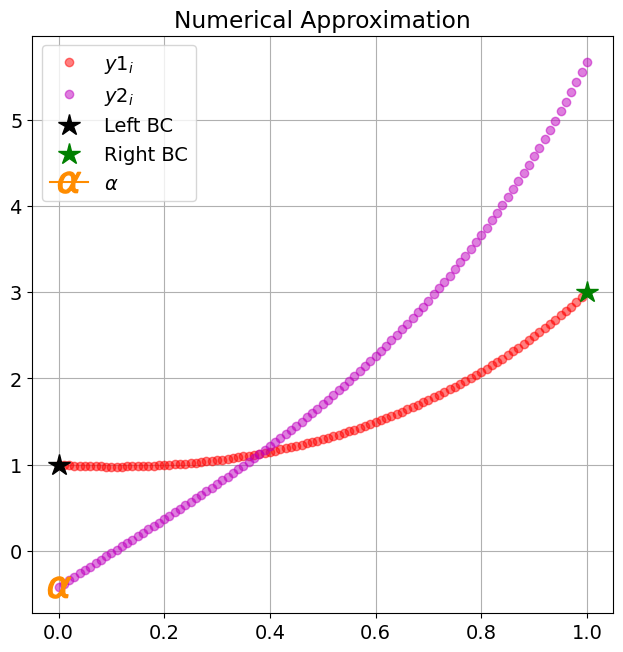

In [18]:
t0 = 0
T  = 1
ya = 1
yb = 3
N  = 100
ODEsolver = RK4

F_root = lambda alpha: F(alpha, ya=ya, yb=yb, N=N, ODEsolver=ODEsolver)
alpha = root(F_root, 0.).x[0]

y0 = np.array([ya,alpha])
t_times, y_output = ODEsolver(t0,T,N,y0,f)

fig = plt.figure(figsize=(L/2,L/2))
plt.grid(True)
plt.title("Numerical Approximation")
plt.plot(t_times,y_output[:,0],'r.',ms=12,alpha=0.5,label=r'$y1_i$')
plt.plot(t_times,y_output[:,1],'m.',ms=12,alpha=0.5,label=r'$y2_i$')
plt.plot(0,ya,'*k',ms=16,label='Left BC')
plt.plot(1,yb,'*g',ms=16,label='Right BC')
plt.plot(0,alpha,'darkorange',ms=16,label=r'$\alpha$', marker=r'$\alpha$')
plt.legend(loc='best')
print(alpha)

### Let's take a look to $F(\alpha, \dots)$, find the 'BUG'!

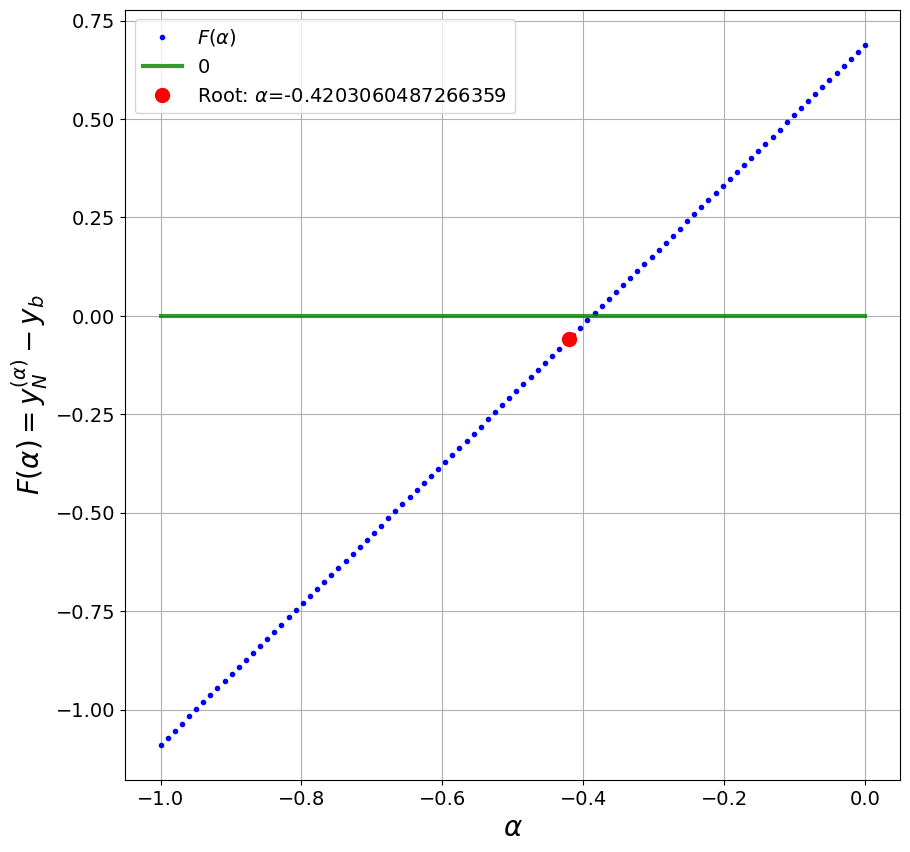

In [19]:
ODEsolver = eulerMethod

several_alphas = np.linspace(-1,0,100)
Fv = np.vectorize(lambda x: F(x,ODEsolver=ODEsolver))
F_alphas = Fv(several_alphas)

plt.figure(figsize=(10,10))
plt.plot(several_alphas,F_alphas,'.b',label=r'$F(\alpha)$')
plt.plot(several_alphas,F_alphas*0,'-g',alpha=0.8,linewidth=3,label=r'$0$')
plt.grid(True)
plt.plot(alpha,F(alpha,ODEsolver=ODEsolver),'.r',ms=20,label=r'Root: $\alpha$='+str(alpha))
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$F(\alpha)=y_N^{(\alpha)} - y_b$')
plt.legend(loc='best')
plt.show()

<div id='DD' />

## Finite Differences
[Back to TOC](#toc)

This method opens a new door of algorithms for solving BVP.
The main idea is to approximate each derivative of $y(x)$ by a finite difference approximation and then solve the linear or possible non-linear system of equations associated.

Here we list a few finite difference approximation for the first and one for the second derivative:

- Forward Difference:
$$ y'(x) = \dfrac{y(x+h) - y(x)}{h} + O(h)$$

- Backward Difference:
$$ y'(x) = \dfrac{y(x) - y(x-h)}{h} + O(h)$$

- Central Difference:
$$ y'(x) = \dfrac{y(x+h) - y(x-h)}{2h} + O(h^2)$$

And for the second derivative:
$$
\begin{align*}
y''(x) &= \dfrac{\text{Forward Difference } - \text{ Backward Difference}}{h} + O(h^2) \\
y''(x) &= \dfrac{\dfrac{y(x+h) - y(x)}{h} - \dfrac{y(x) - y(x-h)}{h}}{h} + O(h^2) \\
y''(x) &= \dfrac{y(x+h) - 2\,y(x) + y(x-h)}{h^2} + O(h^2) \\
\end{align*}
$$

Notice that in all the previous cases we first need to define the function on a grid, it does not have to be regular, but for simplicity we will consider it regular.
Recall that the BVP will be defined on $[a,b]$, thus the regular grid will be defined as follows: $x_i=i\,h$, where $h=\dfrac{b-a}{N}$.
This also help us to define the approximation of the function over the grid, this means the following,
- Traditionally we say $y(x)$ is the function defined on $x\in[a,b]$.
- Now, we will have a grid function $y_i\approx y(x_i)$ for $i\in\{0,1,2,\dots,N\}$. In particular we would like to point out that the vector $\mathbf{y}$ will be the representation of all the scalar values $y_i$ and the vector $\mathbf{x}$ will store the grid values $x_i$. Thus in this discrete world $\mathbf{y}$ will apporximate the continuous function $y(x)$ on $[a,b]$.

On the other hand, the finite difference operator over the finite grid will be then defined as follows:
- Forward Difference: $ y'(x_i)=\dfrac{y_{i+1} - y_i}{h} + O(h) $.
- Backward Difference: $ y'(x_i) = \dfrac{y_i - y_{i-1}}{h} + O(h) $.
- Central Difference: $ y'(x_i) = \dfrac{y_{i+1} - y_{i-1}}{2h} + O(h^2)$.
- Second derivative finite difference: $y''(x_i) = \dfrac{y_{i+1} - 2\,y_i + y_{i-1}}{h^2} + O(h^2)$.

Now, let's apply them!

In [20]:
def solve_finite_difference_eq(M=4,ya=1,yb=3):
    # Spatial discretization, 
    # 'M' represents the number of intervals to be used.
    h=(1.-0.)/M
    
    # Building Finite Difference Discretization
    deltas=-(2.+4.*(h**2.))
    A=toeplitz(np.append(np.array([deltas, 1.]), np.zeros(M-3)))
    # Building RHS
    b=np.append(-ya, np.zeros(M-3))
    b=np.append(b,-yb)
    # Solving the linear system of equations
    y=np.linalg.solve(A, b)
    # Adding back the boundary conditions into the solution
    y=np.append([ya], y)
    y=np.append(y,[yb])
    x_FD = np.linspace(0,1,M+1) # xi, i.e. the spatial grid.
    y_FD = y                    # yi, i.e. the approximation of y(x_i).
    return x_FD, y_FD, A, b

def plot_solution_finite_difference_eq(M=4,ya=1,yb=3, FLAG_test=True):
    
    # Solving with Finite Difference
    x_FD, y_FD, A, b = solve_finite_difference_eq(M,ya,yb)
    
    # Plotting
    fig = plt.figure(figsize=(L,L/2))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # Plotting the discrete solution
    ax1.grid(True)
    ax1.set_title("FD")
    ax1.plot(x_FD,y_FD,'.',ms=20)
    ax1.grid("on")
    
    # Plotting the pattern and coefficients of the tri-diagonal matrix
    plot_matrices_with_values(ax2,A,FLAG_test)
    
interact(plot_solution_finite_difference_eq, M=(3,25,1),
         ya=(-5,5,0.1), yb=(-5,5,0.1), 
         FLAG_test=Checkbox(value=True, description='Show numerical values'))

interactive(children=(IntSlider(value=4, description='M', max=25, min=3), FloatSlider(value=1.0, description='…

<function __main__.plot_solution_finite_difference_eq(M=4, ya=1, yb=3, FLAG_test=True)>

## Comparing the Shooting Method with Finite Differences

In [ ]:
def shooting_method_vs_FD(alpha=-0.420306048726636, N=50, ya=1, yb=3, ODEsolver=eulerMethod, M=4):
    # Shooting Method
    t0 = 0
    T  = 1
    y0 = np.array([ya,alpha])
    t_times, y_output = ODEsolver(t0,T,N,y0,f)
    h = (T-t0)/N
    
    # Finite Differences
    x_FD, y_FD, A, b = solve_finite_difference_eq(M,ya,yb)
    
    
    fig = plt.figure(figsize=(L/2,L/2))
    ax = fig.gca()
    plt.grid(True)
    plt.title("Numerical Approximations")
    plt.plot(t_times,y_output[:,0],'r.',ms=12,alpha=0.5,label=r'SM: $y1_i$')
    plt.plot(t_times,y_output[:,1],'m.',ms=12,alpha=0.5,label=r'SM: $y2_i$')
    
    plt.plot(x_FD,y_FD,'b.',ms=20,label=r'FD: $y_i$')
    
    plt.plot(0,1,'*k',ms=16,label='Left BC')
    plt.plot(1,3,'*g',ms=16,label='Right BC')
    plt.plot(0,alpha,'r',ms=16,label=r'$\alpha$', marker=r'$\alpha$')
    
    plt.legend(loc='best')

interact(shooting_method_vs_FD, alpha=(-2,2,0.01),
         N=(5,100,1), ya=(-5,5,0.1), yb=(-5,5,0.1),
         ODEsolver=radio_button_ODEsolvers,
         M=(3,25,1))

interactive(children=(FloatSlider(value=-0.420306048726636, description='alpha', max=2.0, min=-2.0, step=0.01)…

<function __main__.shooting_method_vs_FD(alpha=-0.420306048726636, N=50, ya=1, yb=3, ODEsolver=<function eulerMethod at 0x11fe3d760>, M=4)>

In summary,
- Both methods find a reasonable approximation.
- The Shooting Method requires to solve several IVP until it find the missing slope $\alpha$, but it uses previous knowledge.
- Finite Different requieres to solve a linear (or possible non-linear) system of equations but we requires few points to get a reasonable approximation.
- Therefore, depending on the numerical problem that needs to be solve, one or the other would be better choice!

<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)

*  _Material creado por profesor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _y ayudantes: Álvaro Salinas y Martín 
Villanueva. DI UTFSM. Abril 2016._
* **DISCLAIMER**: El presente notebook ha sido creado para el curso **ILI286 - Computación Científica 2**, del [Departamento de Informática](http://www.inf.utfsm.cl/), [Universidad Técnica Federico Santa María](http://www.utfsm.cl/). El material ha sido creado por Claudio Torres <ctorres@inf.utfsm.cl> y Sebastian Flores <sebastian.flores@usm.cl>, y es distribuido sin restricciones. En caso de encontrar un error, por favor no dude en contactarnos.
* [Update 2015] Se ha actualizado los notebooks a Python 3 e includio el "magic" "%matplotlib inline" antes de cargar matplotlib para que los gráficos se generen en el notebook. 
* [Update 2016] (Álvaro) Modificaciones mayores al formato original. Agregado contexto: Introducción, Tabla de Contenidos, Explicaciones de cada método.
* [Update 2019] (C. Torres) Small changes. Fixing issue with title of sections and identation. Adding 'interact' to the logistic equation! Adding interact to everything, work in progress. All done, Enjoy!
* _Update July 2021 - v1.16 - C.Torres_ : Updating format and translating to English. Several updates in several functions! Major update!
* _Update July 2021 - v1.17 - C.Torres_ : Minor update, removing commented code.
* _Update July 2021 - v1.18 - C.Torres_ : Removing warning and changing the name of some variables.
* _Update June 2022 - v1.19 - C.Torres_ : Fixing markdown.
* _Update June 2022 - v1.20 - C.Torres_ : Fixing more markdown.
* _Update October 2023 - v1.21 - C.Torres_ : Removing _odeint_ reference and adding solve_ivp. Notice it is not used but it is better to have the recommended reference.
* _Update October 2023 - v1.22 - C.Torres_ : Removing deprecated issues.
* _Update June 2024 - v1.23 - C.Torres_ : Updating the **theoretical definition** of RK4. Thanks Jan Jorquera C.!!
* _Update June 2024 - v1.24 - C.Torres_ : Adding Backward Euler method and removing references to the Stability Regions parts.
* _Update March 2025 - v1.25 - C.Torres_ : Moved to new github repo and some changes on the Acknowledgements section.